### Executive summary
This milestone report for the Data Science Capstone project provides a summary of data preprocessing and exploratory data analysis of the data sets provided. Plans for creating the prediction algorithm and the Shiny app will also be discussed.

In [1]:
library(tm)
library(RWeka)
library(stringi)
library(ggplot2)
library(dplyr)

Loading required package: NLP

Attaching package: ‘ggplot2’

The following object is masked from ‘package:NLP’:

    annotate


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



### Data description and summary statistics
In this project, the following data is provided.

In [2]:
file1 <- file("./final/en_US/en_US.blogs.txt", "rb")
blogs <- readLines(file1, encoding = "UTF-8")
close(file1)

file2 <- file("./final/en_US/en_US.news.txt", "rb")
news <- readLines(file2, encoding = "UTF-8")
close(file2)

file3 <- file("./final/en_US/en_US.twitter.txt", "rb")
twitter <- readLines(file3, encoding = "UTF-8")
close(file3)

Warning message in readLines(file3, encoding = "UTF-8"):
“line 167155 appears to contain an embedded nul”Warning message in readLines(file3, encoding = "UTF-8"):
“line 268547 appears to contain an embedded nul”Warning message in readLines(file3, encoding = "UTF-8"):
“line 1274086 appears to contain an embedded nul”Warning message in readLines(file3, encoding = "UTF-8"):
“line 1759032 appears to contain an embedded nul”

A summary statistics is given below:

In [3]:
words_blogs <- stri_count_words(blogs)
words_news <- stri_count_words(news)
words_twitter <- stri_count_words(twitter)
size_blogs <- file.info("final/en_US/en_US.blogs.txt")$size/1024^2
size_news <- file.info("final/en_US/en_US.news.txt")$size/1024^2
size_twitter <- file.info("fianl/en_US/en_US.twitter.txt")$size/1024^2
summary_table <- data.frame(filename = c("blogs","news","twitter"),
                            file_size_MB = c(size_blogs, size_news, size_twitter),
                            num_lines = c(length(blogs), length(news), length(twitter)),
                            num_words = c(sum(words_blogs), sum(words_news), sum(words_twitter)),
                            mean_num_words = c(mean(words_blogs),mean(words_news),mean(words_twitter)))

summary_table

filename,file_size_MB,num_lines,num_words,mean_num_words
blogs,200.4242,899288,37546239,41.75107
news,196.2775,1010242,34762395,34.40997
twitter,NA,2360148,30093372,12.75063


### Data preprocessing
We will randomly choose 1% of each data set to demonstrate data preprocessing and exploratory data analysis. The full dataset will be used later in creating the prediction algorithm.

In [4]:
set.seed(1)
blogsSample <- sample(blogs, length(blogs)*0.01)
newsSample <- sample(news, length(news)*0.01)
twitterSample <- sample(twitter, length(twitter)*0.01)
twitterSample <- sapply(twitterSample, function(row) iconv(row, "latin1", "ASCII", sub = ""))

We combine the three samples. The number of lines and total number of words are as follows:

In [5]:
text_sample <- c(blogsSample, newsSample, twitterSample)
length(text_sample)
sum(stri_count_words(text_sample))
text_sample <- enc2utf8(text_sample)

[1] 42695

[1] 1020011

In [6]:
file0 <- file("profanities.RData", "rb")
profanities <- readLines(file0, encoding="UTF-8")
profanities <- enc2utf8(profanities)
close(file0)

Warning message in readLines(file0, encoding = "UTF-8"):
“line 1 appears to contain an embedded nul”Warning message in readLines(file0, encoding = "UTF-8"):
“line 3 appears to contain an embedded nul”Warning message in readLines(file0, encoding = "UTF-8"):
“incomplete final line found on 'profanities.RData'”

The basic procedure for data preprocessing consists of the following key steps:

1. Construct a corpus from the files.

2. Tokenization. Clean up the corpus by removing special characters, punctuation, numbers etc. We also remove profanity that we do not want to predict.

3. Build basic n-gram model.

We will require the following helper functions in order to prepare our corpus.

In [7]:
toSpace <- content_transformer(function(x, pattern) gsub(pattern, " ", x))
preprocessCorpus <- function(corpus){
  # Helper function to preprocess corpus
  corpus <- tm_map(corpus, toSpace, "/|@|\\|")
  corpus <- tm_map(corpus, content_transformer(tolower))
  corpus <- tm_map(corpus, removeNumbers)
  corpus <- tm_map(corpus, removePunctuation)
  corpus <- tm_map(corpus, removeWords, stopwords("english"))
  corpus <- tm_map(corpus, removeWords, profanities)
  corpus <- tm_map(corpus, stripWhitespace)
  return(corpus)
}

freq_frame <- function(tdm){
  # Helper function to tabulate frequency
  freq <- sort(rowSums(as.matrix(tdm)), decreasing = TRUE)
  freq_frame <- data.frame(word=names(freq), freq=freq)
  return(freq_frame)
}

BigramTokenizer <- function(x) NGramTokenizer(x, Weka_control(min=2, max=2))
trigramTokenizer <- function(x) NGramTokenizer(x, Weka_control(min=3, max=3))
QuadgramTokenizer <- function(x) NGramTokenizer(x, Weka_control(min=4, max=4))

We preprocess the text sample to form Term Document Matrices.

In [8]:
text_sample <- VCorpus(VectorSource(text_sample))

#text_sample <- preprocessCorpus(text_sample)

tdm1a <- TermDocumentMatrix(text_sample)
tdm1 <- removeSparseTerms(tdm1a, 0.99)
freq1_frame <- freq_frame(tdm1)

tdm2a <- TermDocumentMatrix(text_sample, control = list(tokenize=BigramTokenizer))
tdm2 <- removeSparseTerms(tdm2a, 0.999)
freq2_frame <- freq_frame(tdm2)

tdm3a <- TermDocumentMatrix(text_sample, control = list(tokenize=trigramTokenizer))
tdm3 <- removeSparseTerms(tdm3a, 0.9999)
freq3_frame <- freq_frame(tdm3)

tdm4a <- TermDocumentMatrix(text_sample, control = list(tokenize=QuadgramTokenizer))
tdm4 <- removeSparseTerms(tdm4a, 0.9999)
freq4_frame <- freq_frame(tdm4)

### Exploratory analysis
For each Term Document Matrix, we list the most common unigrams, bigrams, trigrams and fourgrams.

In [9]:
n <- 15
freq1_top15 <- freq1_frame[1:n,]
freq2_top15 <- freq2_frame[1:n,]
freq3_top15 <- freq3_frame[1:n,]
freq4_top15 <- freq4_frame

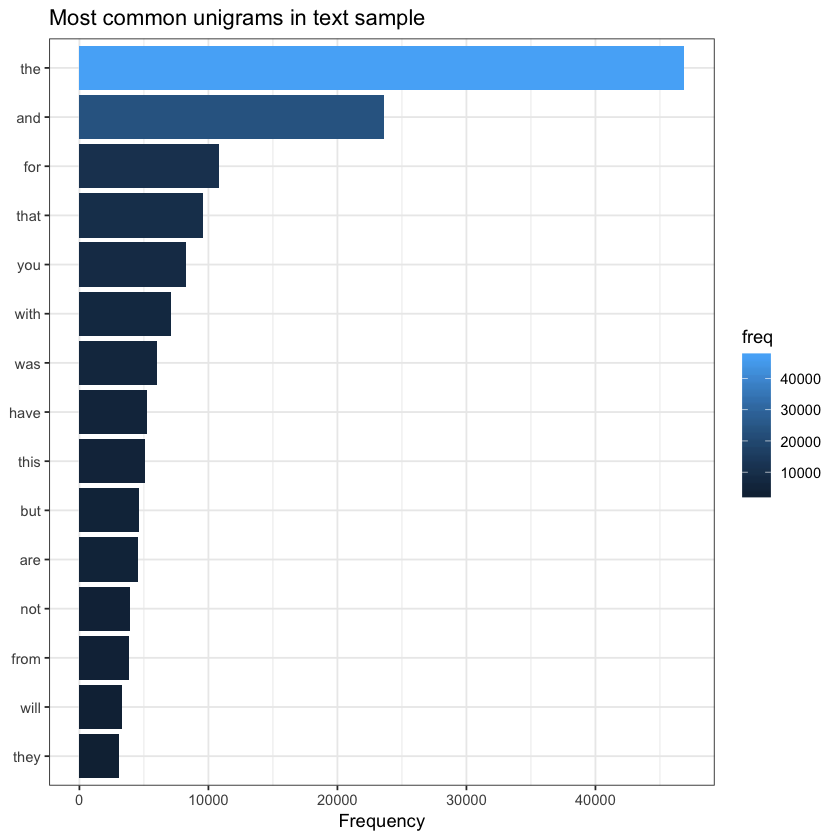

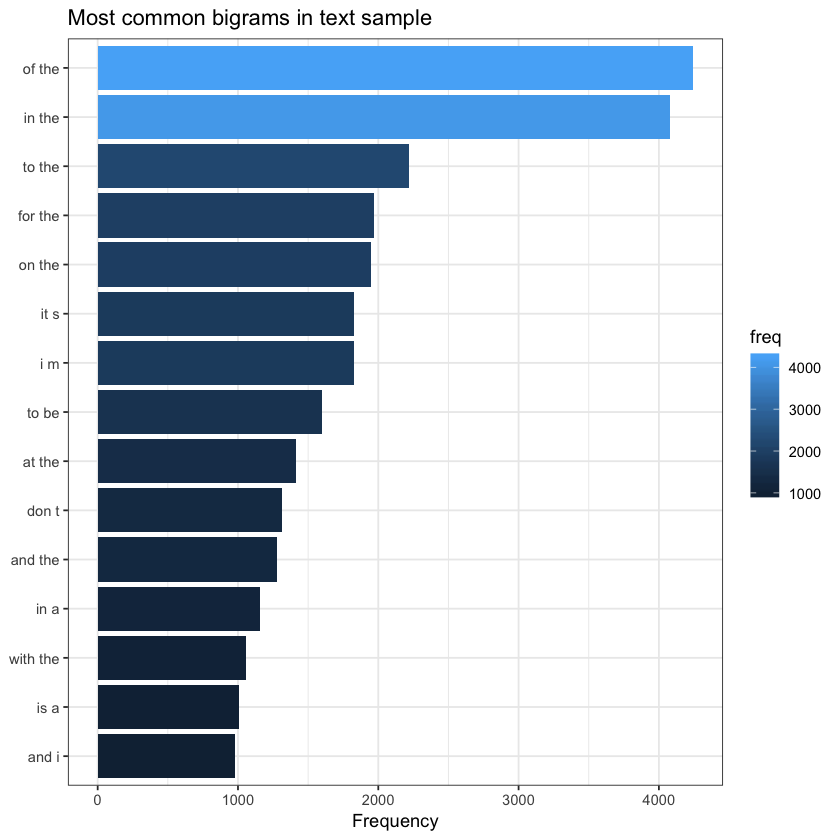

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'i don’t know if' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'i don’t know if' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'i don’t know if' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'you don’t want to' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'you don’t want to' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'you don’t want to' in 'mbcsToSbcs': dot substituted for <99>”Warn

“conversion failure on 'you don’t want to' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'you don’t want to' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'you don’t have to' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'you don’t have to' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'you don’t have to' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'don’t get me wrong' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,

“conversion failure on 'you don’t have to' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'don’t get me wrong' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'don’t get me wrong' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'don’t get me wrong' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'i’m not going to' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'i’m not going to' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,

“conversion failure on 'i’m not going to' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'i’m not going to' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'i’m not going to' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'i don’t know if' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'i don’t know if' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'i don’t know if' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conver

“conversion failure on 'i don’t know if' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'i don’t know if' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'you don’t want to' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'you don’t want to' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'you don’t want to' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'you don’t have to' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“c

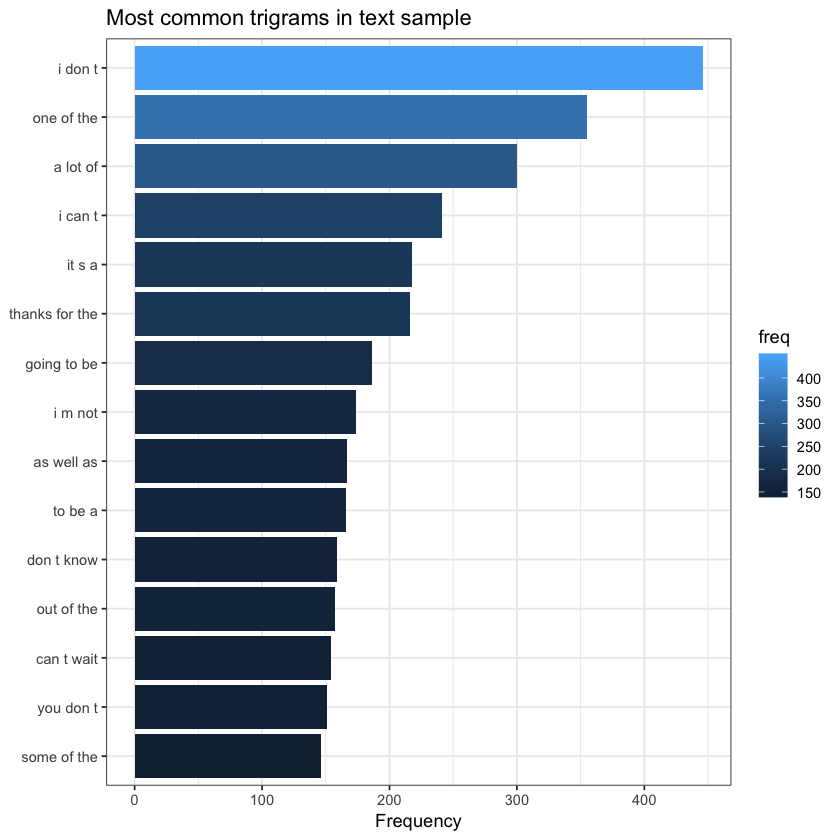

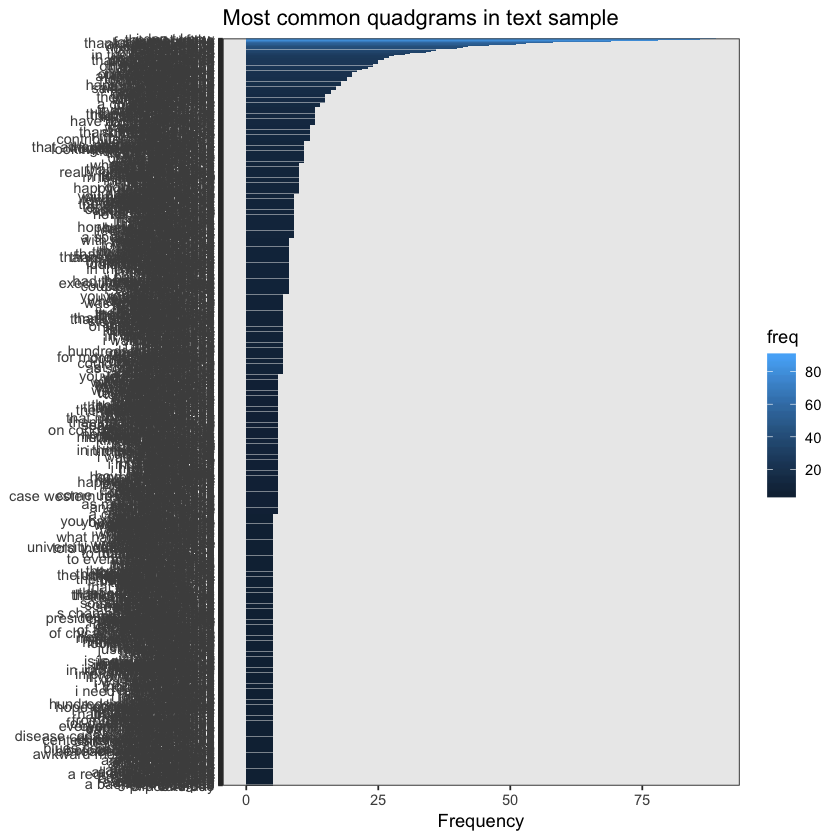

In [10]:
#wordcloud(freq1_frame$word, freq1_frame$freq, min.freq=200)

ggplot(freq1_top15, aes(x=reorder(word, freq), y=freq, fill=freq)) + 
  geom_bar(stat="identity") + 
  theme_bw() + 
  coord_flip() + 
  theme(axis.title.y = element_blank()) + 
  labs(y="Frequency", title = "Most common unigrams in text sample")

ggplot(freq2_top15, aes(x=reorder(word, freq), y=freq, fill=freq)) + 
  geom_bar(stat = "identity") + 
  theme_bw() + 
  coord_flip() + 
  theme(axis.title.y = element_blank()) + 
  labs(y="Frequency", title = "Most common bigrams in text sample")

ggplot(freq3_top15, aes(x=reorder(word, freq), y=freq, fill=freq)) + 
  geom_bar(stat = "identity") + 
  theme_bw() + 
  coord_flip() + 
  theme(axis.title.y = element_blank()) + 
  labs(y="Frequency", title = "Most common trigrams in text sample")

ggplot(freq4_top15, aes(x=reorder(word, freq), y=freq, fill=freq)) + 
  geom_bar(stat = "identity") + 
  theme_bw() + 
  coord_flip() + 
  theme(axis.title.y = element_blank()) + 
  labs(y="Frequency", title = "Most common quadgrams in text sample")

## Prediction strategies and plans for Shiny app
While the strategy for modeling and prediction has not been finalized, the n-gram model with a frequency look-up table might be used based on the analysis above. A possible method of prediction is to use the 4-gram model to find the most likely next word first. If none is found, then the 3-gram model is used, and so forth. Furthermore, stemming might also be done in data preprocessing.